# Modifying the data from experiment 4

I'm going to try loading an existing model and modifying the data distribution to see how this changes things.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds
from physics_mi.net import print_model_params

In [2]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 2813536937  # found as training mode 3 through trial and error
set_all_seeds(seed)
print(seed)

2813536937


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(LinearLayer(2, dim, use_act=use_act), LinearLayer(dim, 1, use_act=False))

    def forward(self, x):
        return self.layers(x)

## Data

I'm changing the data distribution to be uniformly distributed in the input space as opposed to the output space (as was the case in exp 4). Let's see how this changes the operations.

In [5]:
X = torch.rand(10000, 2)
Y = X[:, 0] * X[:, 1]
Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

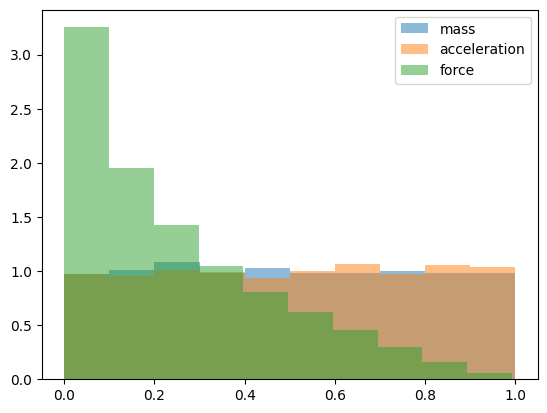

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Load model

In [8]:
model = Net(use_act=True, dim=2)
model.load_state_dict(torch.load("models/e-4.pth"))

<All keys matched successfully>

In [9]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [10]:
print_model_params(model)

layers.0.linear.weight 
 tensor([[ 0.4373, -0.4425],
        [-0.7523, -0.4695]]) 

layers.0.linear.bias 
 tensor([-0.0023,  1.6139]) 

layers.1.linear.weight 
 tensor([[-0.7446, -1.1377]]) 

layers.1.linear.bias 
 tensor([1.3982]) 



## Training

I'll just do full gradient descent to keep things simple.

In [11]:
N = 4000  # number of epochs

loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-4)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [12]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

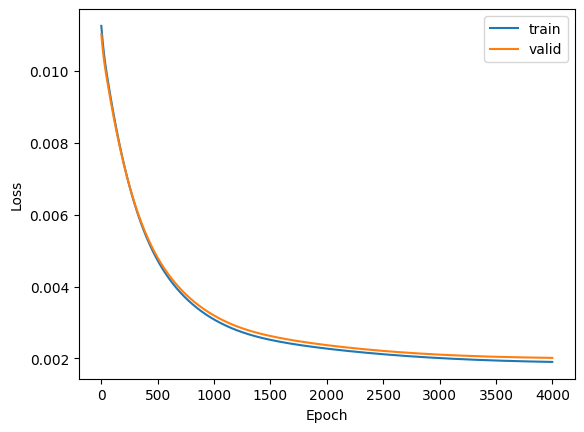

In [13]:
plot_loss(df["train_loss"], df["valid_loss"])

In [14]:
y_preds, y_targs = get_preds(model)

In [15]:
get_valid_loss(model, loss_func)

tensor(0.0020)

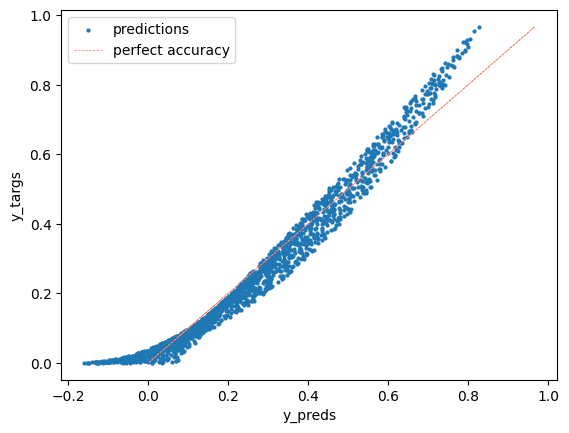

In [16]:
plot_results(y_preds, y_targs)

## Introspection

In [17]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [18]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[ 0.5857, -0.5671],
        [-0.7316, -0.2293]]) 

layers.0.linear.bias 
 tensor([-0.0264,  1.5490]) 

layers.1.linear.weight 
 tensor([[-0.9901, -1.0559]]) 

layers.1.linear.bias 
 tensor([1.4650]) 



### Inspect intermediate values

Going to go operation by operation to see if I can see what's going on.

input ($\rightarrow$ prebias_preacts $\rightarrow$ preacts $\rightarrow$ acts) ($\rightarrow$ prebias $\rightarrow$ output)

(with the layers grouped in brackets)

In [19]:
SD = model.state_dict()

In [20]:
from collections import OrderedDict


def model_breakdown(x1, x2, print_steps=True, return_steps=False):
    x1, x2 = float(x1), float(x2)

    x = torch.tensor([[x1, x2]]).T
    prebias_preacts = torch.matmul(SD["layers.0.linear.weight"], x)
    preacts = prebias_preacts[:, 0] + SD["layers.0.linear.bias"]
    acts = torch.nn.functional.relu(preacts)
    prebias = torch.matmul(SD["layers.1.linear.weight"], acts)
    output = prebias + SD["layers.1.linear.bias"]

    if print_steps:
        print("Input:", "\n", x, "\n")

        print("================ Layer 0 ================", "\n")
        print("Weight:", "\n", SD["layers.0.linear.weight"], "\n")
        print("Result:", "\n", prebias_preacts, "\n")
        print("Bias:", "\n", SD["layers.0.linear.bias"], "\n")
        print("Result:", "\n", preacts, "\n")
        print("Activations:", "\n", acts, "\n")

        print("================ Layer 1 ================", "\n")
        print("Weight:", "\n", SD["layers.1.linear.weight"], "\n")
        print("Result:", "\n", prebias, "\n")
        print("Bias:", "\n", SD["layers.1.linear.bias"], "\n")
        print("Output:", "\n", output, "\n")

        print(f"y_true = {x1*x2:.3f}")

    if return_steps:
        return prebias_preacts, preacts, acts, prebias, output


def plot_model_breakdown(
    x1,
    x2,
    ax=None,
    legend=True,
    color=None,
    product_color=False,
    point_selector={
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
):
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    prebias_preacts, preacts, acts, prebias, output = model_breakdown(*input, print_steps=False, return_steps=True)

    x = OrderedDict()
    x["input"] = input
    x["prebias_preacts"] = prebias_preacts.flatten().tolist()
    x["preacts"] = preacts.flatten().tolist()
    x["acts"] = acts.flatten().tolist()
    x["prebias"] = [float(prebias), 0]
    x["output"] = [float(output), 0]

    markers = {}
    markers["input"] = "v"
    markers["prebias_preacts"] = "o"
    markers["preacts"] = "o"
    markers["acts"] = "o"
    markers["prebias"] = "o"
    markers["output"] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors

In [21]:
model_breakdown(0.75, 1.0)

Input: 
 tensor([[0.7500],
        [1.0000]]) 

================ Layer 0 ================ 

Weight: 
 tensor([[ 0.5857, -0.5671],
        [-0.7316, -0.2293]]) 

Result: 
 tensor([[-0.1278],
        [-0.7780]]) 

Bias: 
 tensor([-0.0264,  1.5490]) 

Result: 
 tensor([-0.1542,  0.7709]) 

Activations: 
 tensor([0.0000, 0.7709]) 

================ Layer 1 ================ 

Weight: 
 tensor([[-0.9901, -1.0559]]) 

Result: 
 tensor([-0.8140]) 

Bias: 
 tensor([1.4650]) 

Output: 
 tensor([0.6509]) 

y_true = 0.750


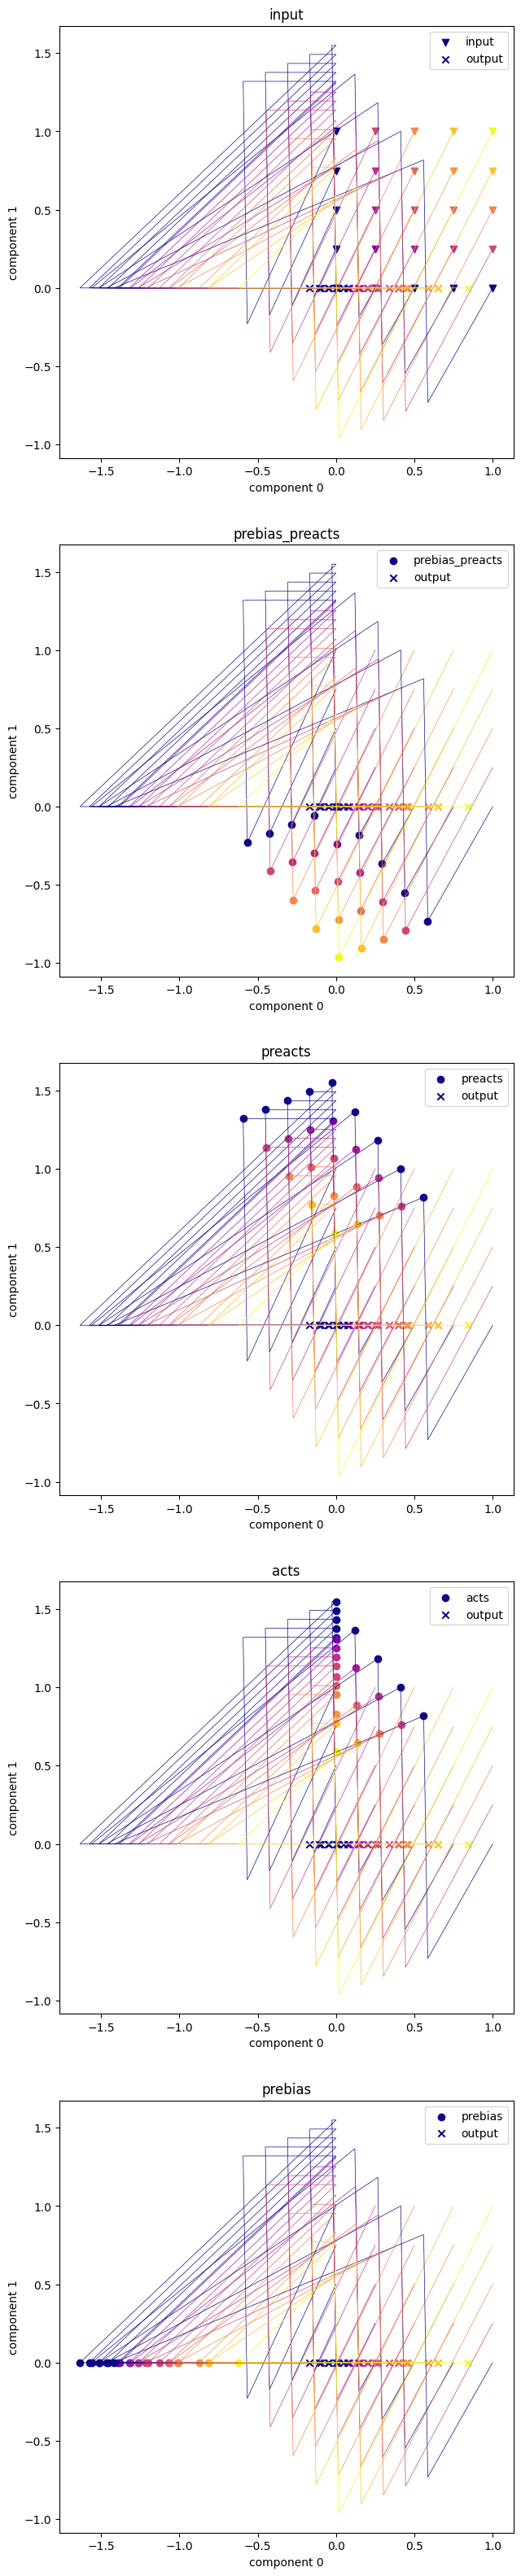

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(10, 40))

N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

# cols = get_colors(len(pairs))

subsets = [
    {
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": True,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": True,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": True,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": True,
        "output": True,
    },
]

titles = ["input", "prebias_preacts", "preacts", "acts", "prebias"]

for ax, subset, title in zip(axes.flatten(), subsets, titles):
    plot_model_breakdown(*pairs[0], ax, product_color=True, point_selector=subset)
    for pair in pairs[1:]:
        plot_model_breakdown(*pair, ax, legend=False, product_color=True, point_selector=subset)
    ax.set_title(title)
    ax.set_aspect("equal")

So, starting from the weights trained on the data uniformly distributed in Y, I've modified the data to now be uniformly distributed in X and we can see that the skew at the `preacts` stage has shifted to be stretched more between the opposite corners of low product value (need to find a more accurate way of describing skew!).

Intuitively following the result of this, we can see this focuses the accuracy on the lower region of the output i.e. the values < 0.5 in product are more accurately predicted than those > 0.5. This makes sense as our distribution in Y is more densely distributed in this region and will contribute more to the loss.

Maybe I should look at a more quantified way of presenting this but perhaps intuitive understanding is ok on this particular point 🤔

In the longer run, **I'm interested in how/if this generalises to a higher-dimensional hidden layer** so I can then perhaps start to investigate whether it appears in larger networks trained on real data. But I'd like to make sure I understand this algorithm fully first.

Maybe what I do now is hand-build a version of this algorithm to see how it compares. Further training and loss evaluations will hopefully be informative in explaining whether I've captured all the important elements.

In [24]:
# torch.save(model.state_dict(), 'models/e-5.pth')